In [10]:
import numpy as np
import scipy.stats as sps

import statsmodels as sm
import statsmodels.api as sma
from scipy.stats import bernoulli

import random
import math
import pandas as pd

from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt


def generate_data(dims, n, p_0, eta):
    
    p1 = []
    for h in range(len(p_0)):
        p1.append(p_0[0] + eta * (-1)**(h+2))
    data = pd.DataFrame(np.empty((int(n), int(dims))))
    
    for i in range(n):
        data.iloc[i, :] = np.random.multinomial(1, p1, size=1)
    return data

def BitFlipLocalRandomizer(data, epsilon):
    
    tmp = data.copy()
    prob = math.exp(epsilon/2)/(math.exp(epsilon/2) + 1)

    for i in range(np.shape(tmp)[1]):
        for j in range(np.shape(tmp)[0]):
            if random.random() > prob:
                tmp[i][j] = 1 - tmp[i][j]  
    
    return tmp

def get_sigma(p_0, epsilon, dims):
    
    Id = np.eye(dims)
    
    alpha = (math.exp(epsilon/2) - 1) / (math.exp(epsilon/2) + 1)
    
    sigma = alpha**2 * (np.diag(p_0) - p_0 @ p_0.reshape(-1,1)) +  math.exp(epsilon/2) / (math.exp(epsilon/2) + 1)**2 * Id
    
    return sigma

def get_T_bitflip(data, epsilon, p_0, dims, n):
    
    #n - number of people
    #dims = number of traits
    
    sigma = get_sigma(p_0=p_0, epsilon=epsilon, dims=dims)

    #get projection matrix
    Id = np.eye(dims)
    IId = np.ones((dims,dims)) / dims
    Projection_matrix = Id - IId

    H_hat = np.array(BitFlipLocalRandomizer(data=data, epsilon=epsilon).sum(axis=0)).reshape(-1,1)
    
    p_mean_vector = (((math.exp(epsilon/2)-1) * p_0 + 1) / (math.exp(epsilon/2) + 1)).reshape(-1, 1)
    q = n * (H_hat / n - p_mean_vector).T @ Projection_matrix @ np.linalg.inv(sigma) @ Projection_matrix @ (H_hat / n - p_mean_vector)
    
    
    if q > sps.chi2(dims-1).ppf(0.95,):
#         print('Null hypothesis rejected')
        return 1
    else:
#         print('Fail to reject the Null hypothesis')
        return 0

def process(params):
    epsilon, dims, p_0, n, eta = params[0], params[1], params[2], int(params[3]), params[4]
    data = generate_data(dims=dims, n=n, p_0=p_0, eta=eta)
    if get_T_bitflip(data=data, epsilon=epsilon, p_0=p_0, dims=dims, n=n):
        return 1
    else:
        return 0
    

def calculate_bitflip_power(trials,epsilon, dims, p_0, n, eta):
    params = [epsilon, dims, p_0, n, eta]
    params = [params] * trials
    res = Parallel(n_jobs=12)(delayed(process)(params) for params in tqdm(params))
    return sum(res) / trials

def non_private_chi2(trials, n, dims,  p_0):
    p_0 = np.array(p_0)
    
    p1 = []
    for h in range(len(p_0)):
        p1.append(p_0[0] + eta * (-1)**(h+2))
        
    p1 = np.array(p1)
    
    tmp_res = []
    for rep in range(trials):
        
        data = pd.DataFrame(np.empty((int(n), int(dims))))
        for i in range(n):
            data.iloc[i, :] = np.random.multinomial(1, p1, size=1)

        H = data.sum(axis=0)
        T = sum((H - n * p_0)**2 / (n * p_0))

        if T > sps.chi2(dims-1).ppf(0.95):
            tmp_res.append(1)
        else:
            tmp_res.append(0)
    return sum(tmp_res) / len(tmp_res)

In [11]:
dims=4
eta=0.01
p_0=np.array([1 / dims] * dims)

n_vector = np.linspace(300, 30000, 10)
results = pd.DataFrame(np.empty((3,len(n_vector))))

i = 0
j = 0

for e in [1,2,4]:
    for n in n_vector:
        results.iloc[i,j] = calculate_bitflip_power(trials=100, epsilon=e, dims=int(dims), p_0=p_0, n=int(n), eta=eta)
        j+=1
    i+=1
    j=0

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.63it/s]


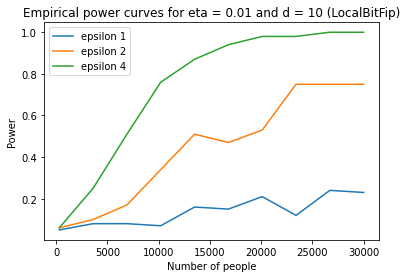

In [12]:
results.columns = n_vector
plt.plot(results.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.ylabel('Power')
plt.title('Empirical power curves for eta = 0.01 and d = 4 (LocalBitFlip)')
plt.xlabel('Number of people')
plt.legend()

In [14]:
nonprivate_res4=[]

for n in tqdm(n_vector):
    nonprivate_res4.append(non_private_chi2(trials = 25, n=int(n), dims = dims,  p_0=[1/dims] * dims))
    

100%|███████████████████████████████████████████| 10/10 [04:37<00:00, 27.72s/it]


In [15]:
test = pd.DataFrame(np.empty((1,10)))
test.iloc[0, :] = nonprivate_res4
test.columns = n_vector

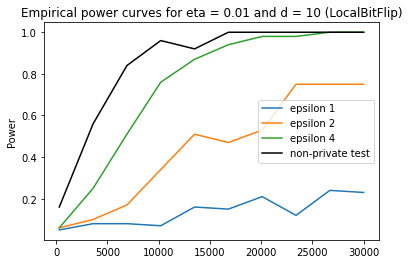

In [16]:
results.columns = n_vector
plt.plot(results.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.plot(test.T, label = 'non-private test', color='black')
plt.ylabel('Power')
plt.title('Empirical power curves for eta = 0.01 and d = 10 (LocalBitFlip)')
plt.legend()

In [17]:
dims=10
eta=0.01
p_0=np.array([1 / dims] * dims)

n_vector = np.linspace(300, 30000, 10)
results_10 = pd.DataFrame(np.empty((3,len(n_vector))))

i = 0
j = 0

for e in [1,2,4]:
    for n in n_vector:
        results_10.iloc[i,j] = calculate_bitflip_power(trials=100, epsilon=e, dims=int(dims), p_0=p_0, n=int(n), eta=eta)
        j+=1
    i+=1
    j=0
    


100%|█████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


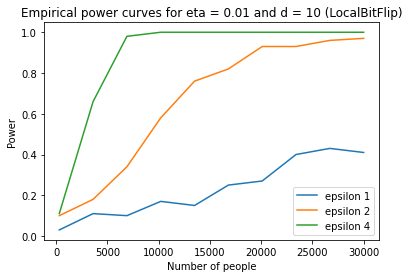

In [31]:
results_10.columns = n_vector
plt.plot(results_10.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.ylabel('Power')
plt.title('Empirical power curves for eta = 0.01 and d = 10 (LocalBitFlip)')
plt.xlabel('Number of people')
plt.legend()

In [19]:
nonprivate_res10=[]

for n in tqdm(n_vector):
    nonprivate_res10.append(non_private_chi2(trials = 25, n=int(n), dims = dims,  p_0=[1/dims] * dims))
    

100%|███████████████████████████████████████████| 10/10 [04:36<00:00, 27.68s/it]


In [20]:
test10 = pd.DataFrame(np.empty((1,10)))
test10.iloc[0, :] = nonprivate_res10
test10.columns = n_vector

In [25]:
test10

,300.0,3600.0,6900.0,10200.0,13500.0,16800.0,20100.0,23400.0,26700.0,30000.0
0,0.16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


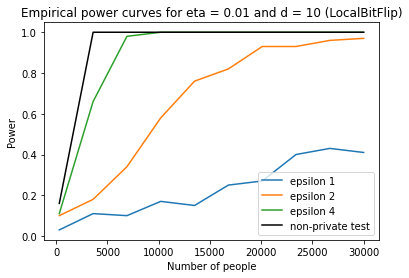

In [32]:
results.columns = n_vector
plt.plot(results_10.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.ylabel('Power')
plt.plot(test10.T, label = 'non-private test', color='black')

plt.title('Empirical power curves for eta = 0.01 and d = 10 (LocalBitFlip)')
plt.xlabel('Number of people')
plt.legend()

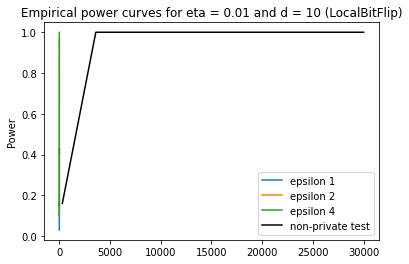

In [26]:
results.columns = n_vector
plt.plot(results_10.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.plot(test10.T, label = 'non-private test', color='black')
plt.ylabel('Power')
plt.title('Empirical power curves for eta = 0.01 and d = 10 (LocalBitFlip)')
plt.legend()

100%|███████████████████████████████████████████| 10/10 [01:48<00:00, 10.85s/it]


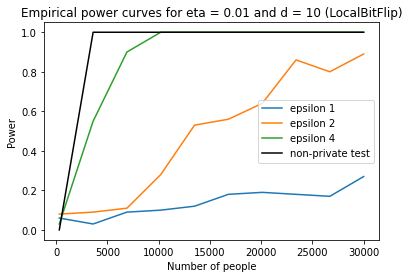

[[44.97610882]]
[[50.34425004]]
[[38.00369146]]
[[42.58008911]]
[[30.09964526]]
[[34.92233964]]
[[39.4300279]]
[[48.05816535]]
[[33.17641645]]
[[43.05071906]]
[[42.5165476]]
[[33.24169037]]
[[35.12928997]]
[[32.03325666]]
[[38.81408053]]
[[35.58908498]]
[[42.45124432]]
[[43.5211141]]
[[49.53197791]]
[[42.35985139]]
[[60.6112711]]
[[42.900641]]
[[46.48362498]]
[[32.67312976]]
[[32.18189976]]
[[49.40627879]]
[[24.31315042]]
[[41.44300572]]
[[41.55716901]]
[[30.59957602]]
[[42.87047177]]
[[35.74977479]]
[[72.13668148]]
[[50.72498089]]
[[22.87145902]]
[[49.21166437]]
[[35.20426346]]
[[38.24235382]]
[[59.76030213]]
[[47.76422228]]
[[46.42495688]]
[[48.42875756]]
[[39.04634371]]
[[35.50478384]]
[[46.24060431]]
[[42.0375555]]
[[23.35854951]]
[[58.2533236]]
[[45.24349027]]
[[60.07716776]]
[[41.34805175]]
[[34.83276575]]
[[32.80825494]]
[[48.3294215]]
[[42.65840677]]
[[65.75309172]]
[[52.02968372]]
[[41.8058897]]
[[44.36662262]]
[[46.14262227]]
[[63.31952244]]
[[44.00649331]]
[[49.10979846]]
[[

In [33]:
dims=40
eta=0.005
p_0=np.array([1 / dims] * dims)

n_vector = np.linspace(300, 30000, 10)
results_new = pd.DataFrame(np.empty((3,len(n_vector))))

i = 0
j = 0

for e in [1,2,4]:
    for n in n_vector:
        results_new.iloc[i,j] = calculate_bitflip_power(trials=100, epsilon=e, dims=int(dims), p_0=p_0, n=int(n), eta=eta)
        j+=1
    i+=1
    j=0

nonprivate_resnew=[]

for n in tqdm(n_vector):
    nonprivate_resnew.append(non_private_chi2(trials = 10, n=int(n), dims = dims,  p_0=[1/dims] * dims))

results_new.columns = n_vector

testnew = pd.DataFrame(np.empty((1,10)))
testnew.iloc[0, :] = nonprivate_resnew
testnew.columns = n_vector


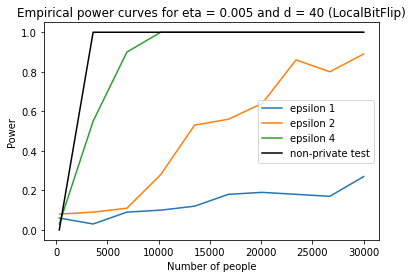

In [34]:
plt.plot(results_new.T, label = ['epsilon 1', 'epsilon 2', 'epsilon 4'])
plt.ylabel('Power')
plt.plot(testnew.T, label = 'non-private test', color='black')
plt.title('Empirical power curves for eta = 0.005 and d = 40 (LocalBitFlip)')
plt.xlabel('Number of people')
plt.legend()